# About 
Results are loaded from the BSA code. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import pickle 

%matplotlib inline 

In [2]:
path_to_input = '../results/phi/sys.csv'
data = pd.read_csv(path_to_input)

In [3]:
data['axis_value'] = data['axis_min'] + 0.5 * (data['axis_max'] - data['axis_min'])

### Sources 
The file contains numerical sources which need to be correlated to string names that are contained in the file `systematic_sources.pkl` which is produced by the code `bsa.py`.

In [4]:
# Numerical names 
systematics = [col for col in data.columns if 'sys' in col and col != 'sys_total']
print('Systematics: ', systematics)

# String names 
with open('../systematic_sources.pkl', 'r') as inputfile:
    systematic_sources = pickle.load(inputfile)
    
for sys in systematics:
    print(sys, systematic_sources[sys])

('Systematics: ', ['sys_0', 'sys_1', 'sys_10', 'sys_11', 'sys_12', 'sys_2', 'sys_3', 'sys_4', 'sys_5', 'sys_6', 'sys_7', 'sys_8', 'sys_9'])
('sys_0', 'beam_pol')
('sys_1', u'dist_dcr3')
('sys_10', u'dist_ecu')
('sys_11', u'dist_cc')
('sys_12', u'dist_ecv')
('sys_2', u'dist_dcr1')
('sys_3', u'dist_vz')
('sys_4', u'dist_ecsf')
('sys_5', u'dist_ecw')
('sys_6', u'dist_ec_edep')
('sys_7', u'p_mes')
('sys_8', u'alpha')
('sys_9', u'missing_mass')


### Human Readable Names 
Here I will setup human readable names for the abbreviations used in the dictionary.  These are used during plotting. 

In [5]:
systematic_names = {}
systematic_names['beam_pol'] = 'Beam polarization'
systematic_names['dist_dcr1'] = 'Fid. DC R1'
systematic_names['dist_dcr3'] = 'Fid. DC R3'
systematic_names['dist_cc'] = 'Fid. CC'
systematic_names['dist_ecu'] = 'EC-U'
systematic_names['dist_ecv'] = 'EC-V'
systematic_names['dist_ecw'] = 'EC-W'
systematic_names['dist_vz'] = 'z-vertex'
systematic_names['dist_ecsf'] = 'Sampling fraction'
systematic_names['p_mes'] = 'Kaon momentum'
systematic_names['alpha'] = 'Confidence (Kaon ID)'
systematic_names['dist_ec_edep'] = 'EC energy deposition'
systematic_names['missing_mass'] = 'Missing mass'

### Plotting Options 
Setup some basic plotting options.  Using the latex titles makes it slow.

In [6]:
plt.rc('font', family='serif')
plt.rc('font', size=16)
plt.rc('text', usetex=True)

### Plot Averaged Systematics 
This bar-plot shows for a given axis the relative contribution of each source.

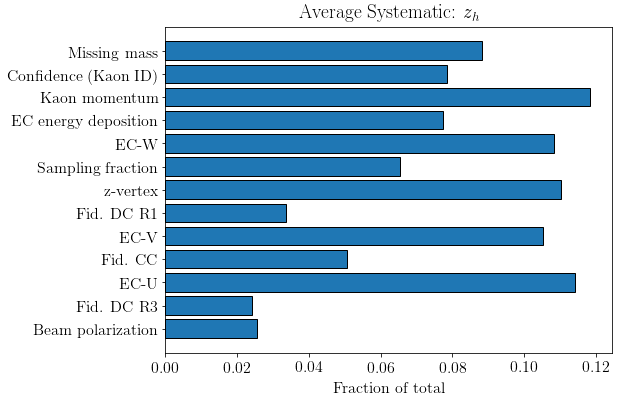

In [7]:
idx = np.where(data['axis'].values == 'z')
errs = [np.mean(np.abs(data.iloc[idx][s].values)) for s in systematics]
errs = np.abs(errs)
errs /= np.sum(errs)
names = [systematic_names[systematic_sources[s]] for s in systematics]

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
ax.barh(names, errs, edgecolor='k')
ax.set_xlabel('Fraction of total')
ax.set_title('Average Systematic: $z_h$')
fig.savefig('../image/bar-systematics-z.pdf', bbox_inches='tight')

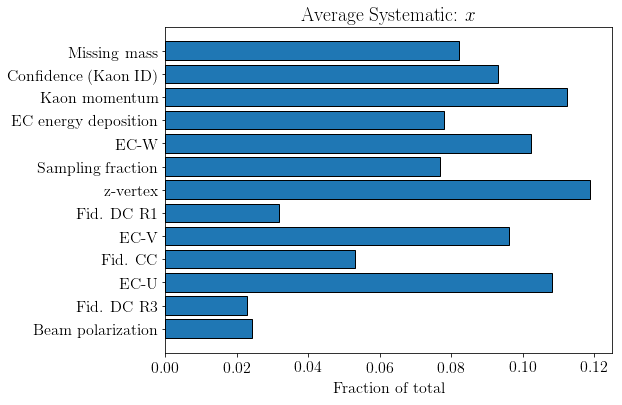

In [8]:
idx = np.where(data['axis'].values == 'x')
errs = [np.mean(np.abs(data.iloc[idx][s].values)) for s in systematics]
errs = np.abs(errs)
errs /= np.sum(errs)
names = [systematic_names[systematic_sources[s]] for s in systematics]

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
ax.barh(names, errs, edgecolor='k')
ax.set_xlabel('Fraction of total')
ax.set_title('Average Systematic: $x$')
fig.savefig('../image/bar-systematics-x.pdf', bbox_inches='tight')

In [135]:
def grid_plot_one_axis(data, axis, display_sys=False):
    
    # First style 
    style = dict(
        linestyle='',
        marker='o',
        color='black'
    )
    
    # Make latex labels 
    tex_labels = {}
    tex_labels['x'] = 'x'
    tex_labels['z'] = 'z'
    tex_labels['q2'] = 'Q^2'
    tex_labels['pt'] = 'P_{T}^{2}'
    
    axis_data = data.iloc[np.where(data['axis'].values == axis)[0]]
    n_bins = axis_data['axis_bin'].nunique()

    n_cols = 4
    n_rows = int(np.floor(n_bins / n_cols) + 1)
    
    fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, 
                            figsize = (4 * n_cols, 3 * n_rows),
                           sharex=True, sharey=True)
    fig.subplots_adjust(wspace=0, hspace=0)
        
    for irow in range(n_rows):
        for icol in range(n_cols):
            index = icol + irow * n_cols 
            
            bin_data = axis_data.iloc[np.where(axis_data['axis_bin'].values == index)[0]]

            if index < n_bins:
                label = '${0} \in [{1:.2f},{2:.2f}]$'.format(tex_labels[axis], 
                                                  bin_data['axis_min'].values[0],
                                                  bin_data['axis_max'].values[0])
                
                axs[irow, icol].errorbar(bin_data['phi'], 
                                         bin_data['value'], 
                                         bin_data['stat'], 
                                         **style)
                axs[irow, icol].set_ylim([-0.11, 0.11])
                axs[irow, icol].set_xlim([-190, 190])
                axs[irow, icol].axhline(0.0, linestyle='--', color='black', alpha=0.6)
                axs[irow, icol].text(0, 0.08, label)
                
                if display_sys:
                    phi_width = float(360.0 / len(bin_data))
                    axs[irow, icol].bar(bin_data['phi'], bin_data['sys_total'], 
                                        color='red', edgecolor='black', width=phi_width)
                
                # Left side of the plot 
                if icol % n_cols == 0:
                    axs[irow, icol].set_ylabel('BSA')
                
                # Bottom of the plot 
                if irow % n_rows == 0:
                    axs[irow, icol].set_xlabel('$\phi_h$')
        
    return fig 

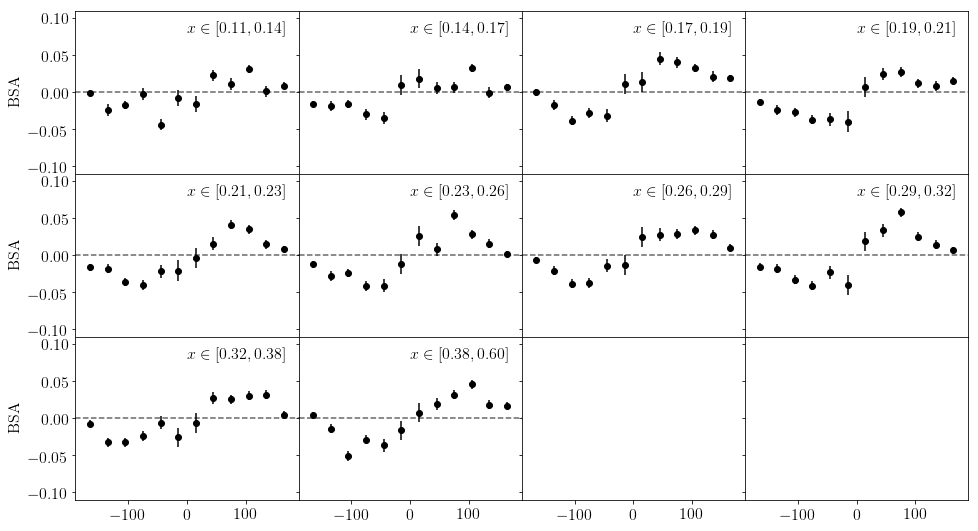

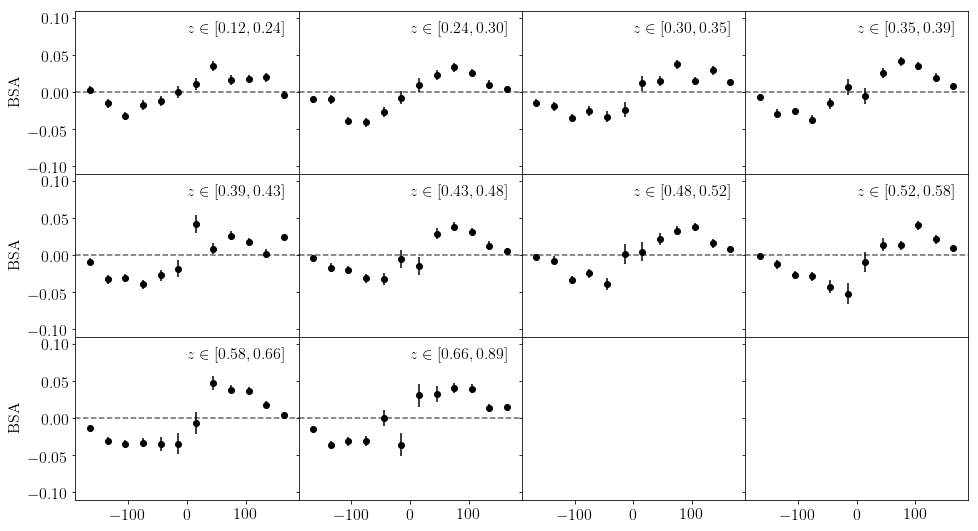

In [137]:
for axis in ['x', 'z']:
    fig = grid_plot_one_axis(data, axis)
    plt.savefig('../image/grid_bsa_{}.pdf'.format(axis), bbox_inches='tight')

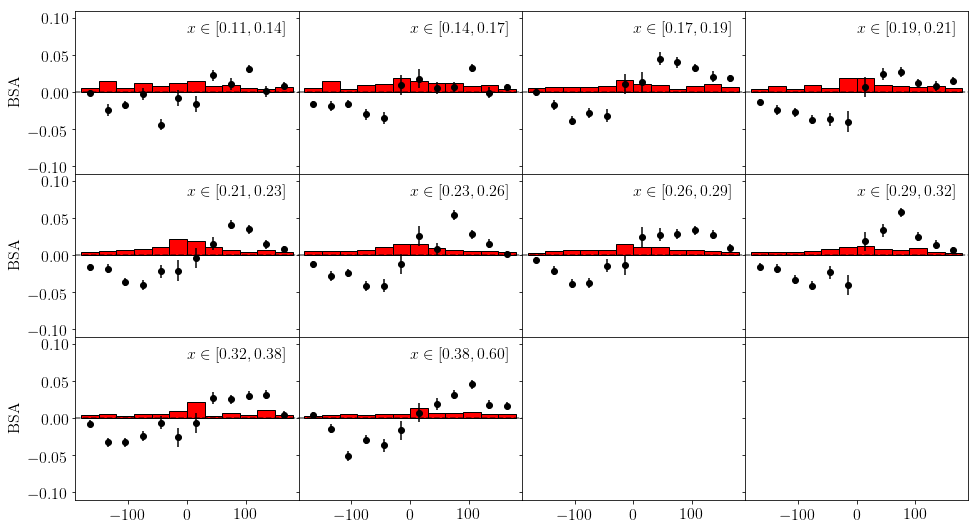

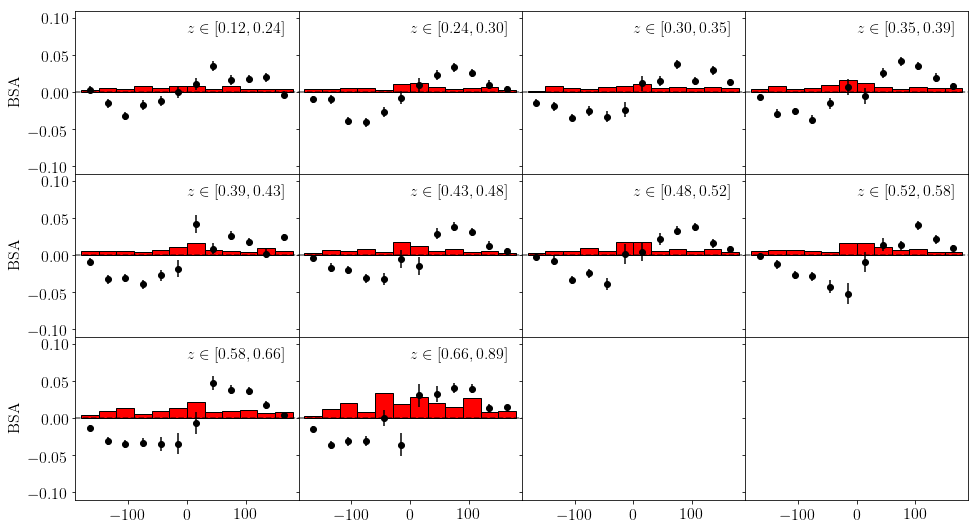

In [138]:
for axis in ['x', 'z']:
    fig = grid_plot_one_axis(data, axis, display_sys=True)
    plt.savefig('../image/grid_bsa_sys_{}.pdf'.format(axis), bbox_inches='tight')